In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
%matplotlib inline

myflag = True
frame_counter=0
final_heatmap = None
final_label = None
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(32, 32),
                        hist_bins=16, hist_range=(0, 1)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                  
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        hog0 = hog_features[0]
        hog1 = hog_features[1]
        hog2 = hog_features[2]
        
        hog_features = np.hstack((hog0,hog1,hog2))
        #######
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

############################################# Reading image paths ###############################
# Divide up into cars and notcars

cars = []
images_cars = glob.glob('./vehicles/GTI_Far/*.png')
for image in images_cars:
    cars.append(image)
    
images_cars = glob.glob('./vehicles/GTI_Left/*.png')
for image in images_cars:
    cars.append(image)
    
images_cars = glob.glob('./vehicles/GTI_MiddleClose/*.png')
for image in images_cars:
    cars.append(image)
    
images_cars = glob.glob('./vehicles/GTI_Right/*.png')
for image in images_cars:
    cars.append(image)
    
images_cars = glob.glob('./vehicles/KITTI_extracted/*.png')
for image in images_cars:
    cars.append(image)

notcars = []    
images_notcars = glob.glob('./non-vehicles/GTI/*.png')
for image in images_notcars:
    notcars.append(image)
    
images_notcars = glob.glob('./non-vehicles/Extras/*.png')
for image in images_notcars:
    notcars.append(image)

print('the size of cars is ',len(cars))
print('the size of not cars is ',len(notcars))

sample_cars = cars[1000]
sample_notcars = notcars[1000]

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 8000
random_idxs = np.random.randint(0,len(cars),sample_size)
cars = np.array(cars)[random_idxs]
notcars = np.array(notcars)[random_idxs]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For the',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

####### clearing memory

cars = None
notcars = None
X_train = None
Y_train = None
X_test = None
Y_test = None
X = None
Y = None
car_features = None
notcar_features = None


the size of cars is  8792
the size of not cars is  8968
321.14 Seconds to extract HOG features...
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4092
23.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9928
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
For the 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
0.02002 Seconds to predict 10 labels with SVC


## Example of how the features extraction works

0

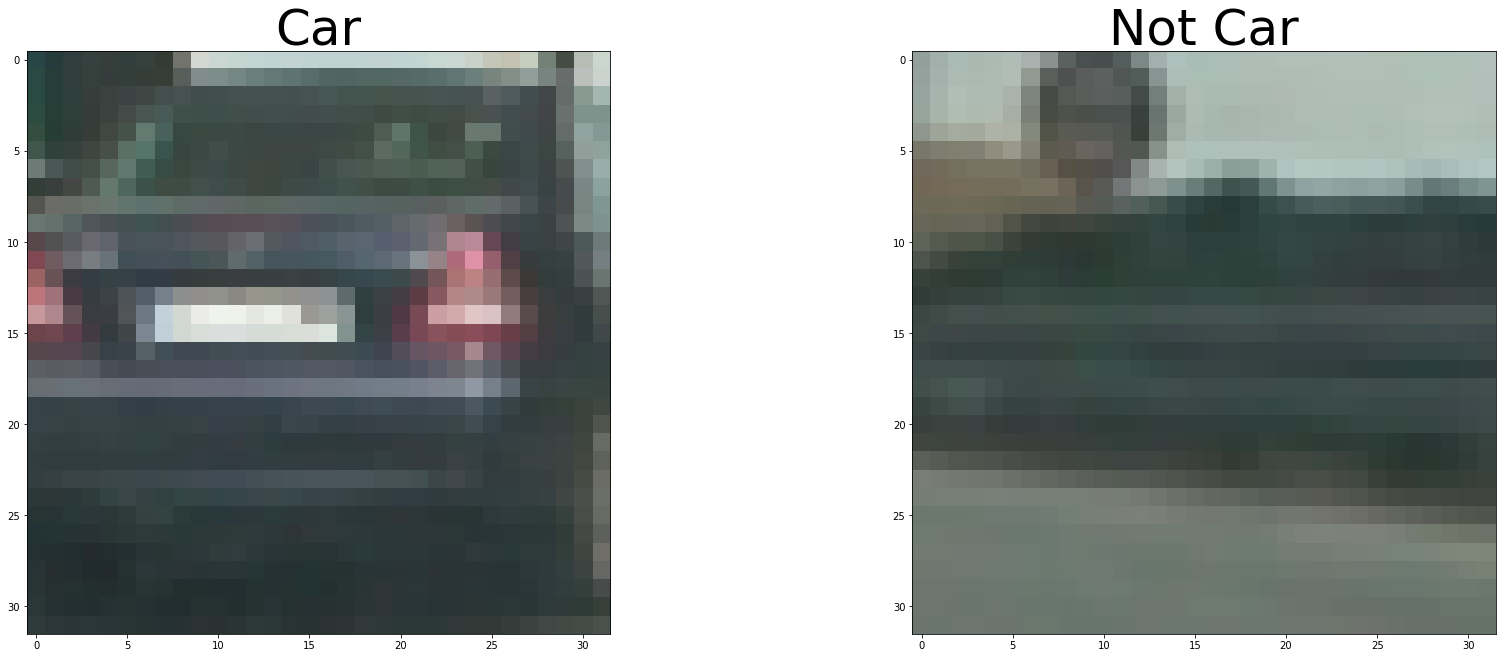

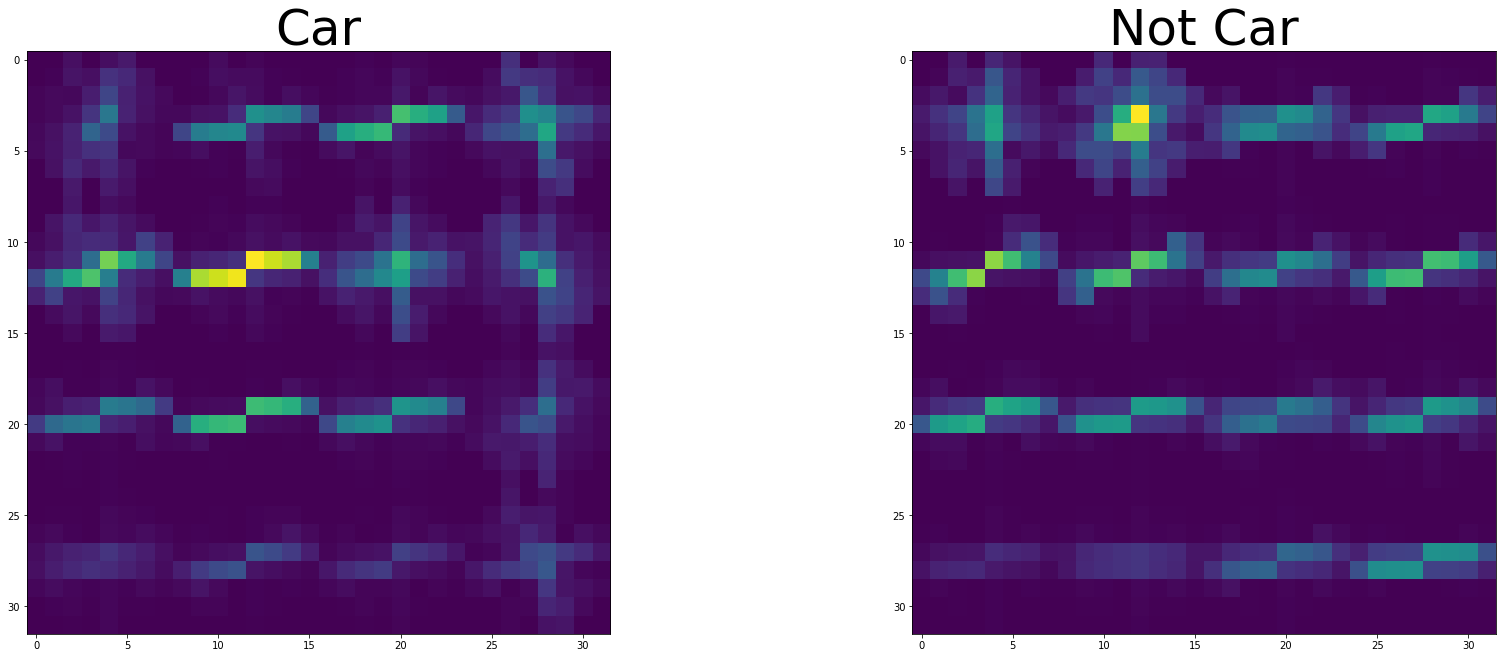

In [2]:
def show_images(path1,path2):
    car_img = mpimg.imread(path1)
    notcar_img = mpimg.imread(path2)
    
    plt.imsave('car_example.jpg',car_img)
    plt.imsave('notcar_example.jpg',notcar_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    img1 = cv2.resize(car_img, (0,0), fx=0.5, fy=0.5) 
    img2 = cv2.resize(notcar_img, (0,0), fx=0.5, fy=0.5) 
    ax1.imshow(img1)
    ax1.set_title('Car', fontsize=50)
    ax2.imshow(img2)
    ax2.set_title('Not Car', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    car_features, car_hog_image = get_hog_features(car_img[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
    notcar_features, notcar_hog_image = get_hog_features(notcar_img[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
    
    plt.imsave('car_hog_example.jpg',car_hog_image)
    plt.imsave('notcar_hog_example.jpg',notcar_hog_image)
    
    f2, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f2.tight_layout()
    img1 = cv2.resize(car_hog_image, (0,0), fx=0.5, fy=0.5) 
    img2 = cv2.resize(notcar_hog_image, (0,0), fx=0.5, fy=0.5) 
    ax1.imshow(img1)
    ax1.set_title('Car', fontsize=50)
    ax2.imshow(img2)
    ax2.set_title('Not Car', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return 0
    
show_images(sample_cars,sample_notcars)
    
    

** Now to test it on sample images : **

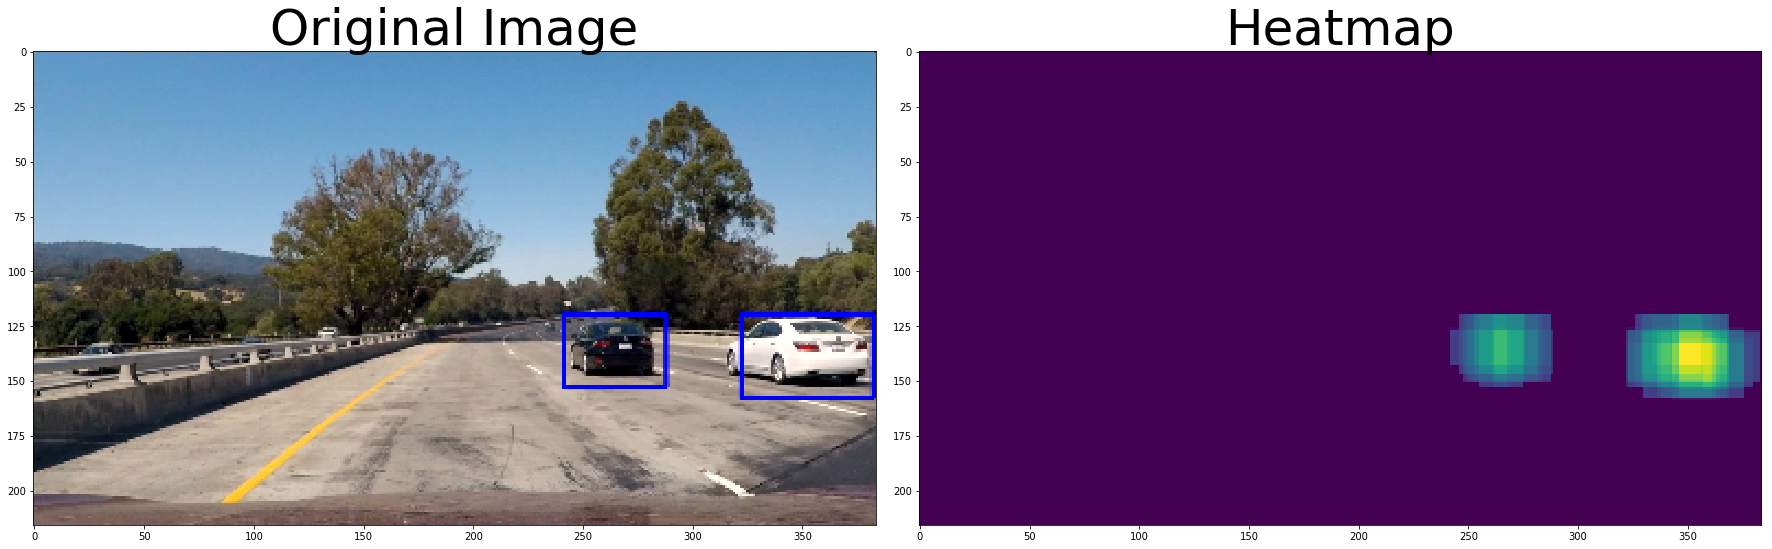

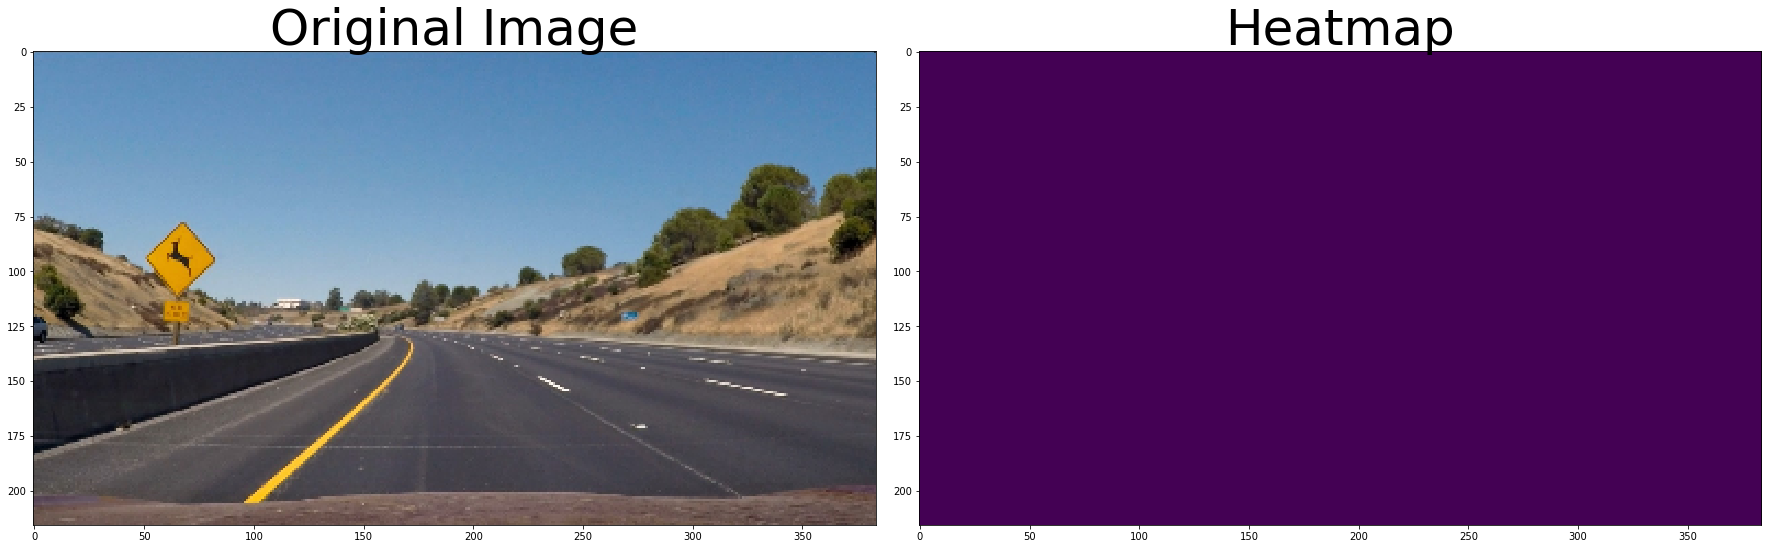

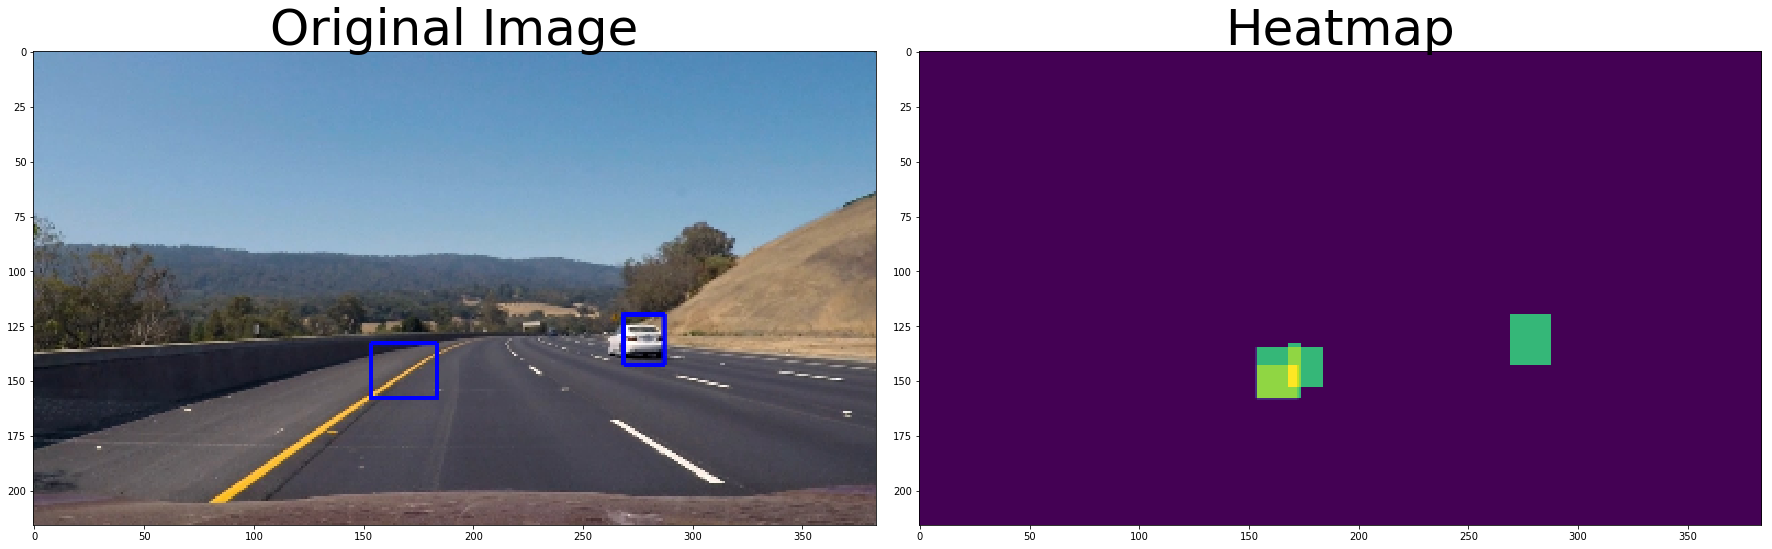

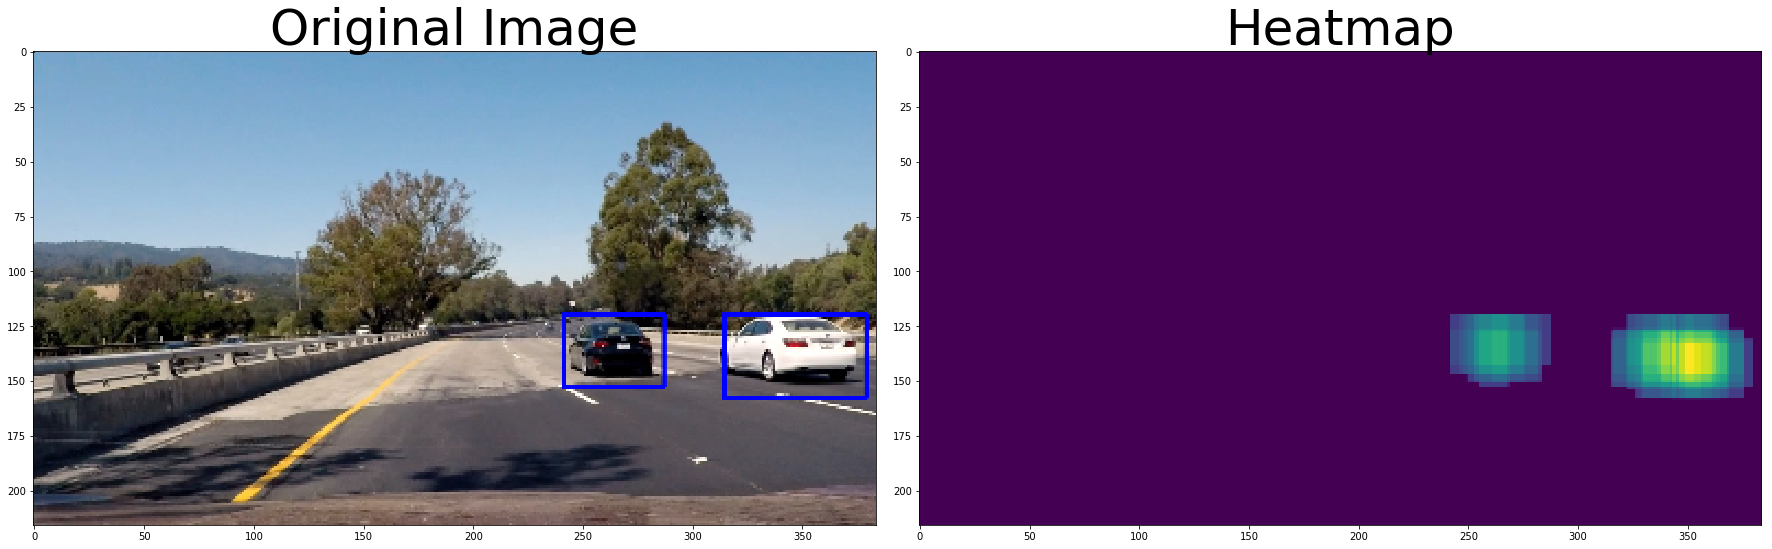

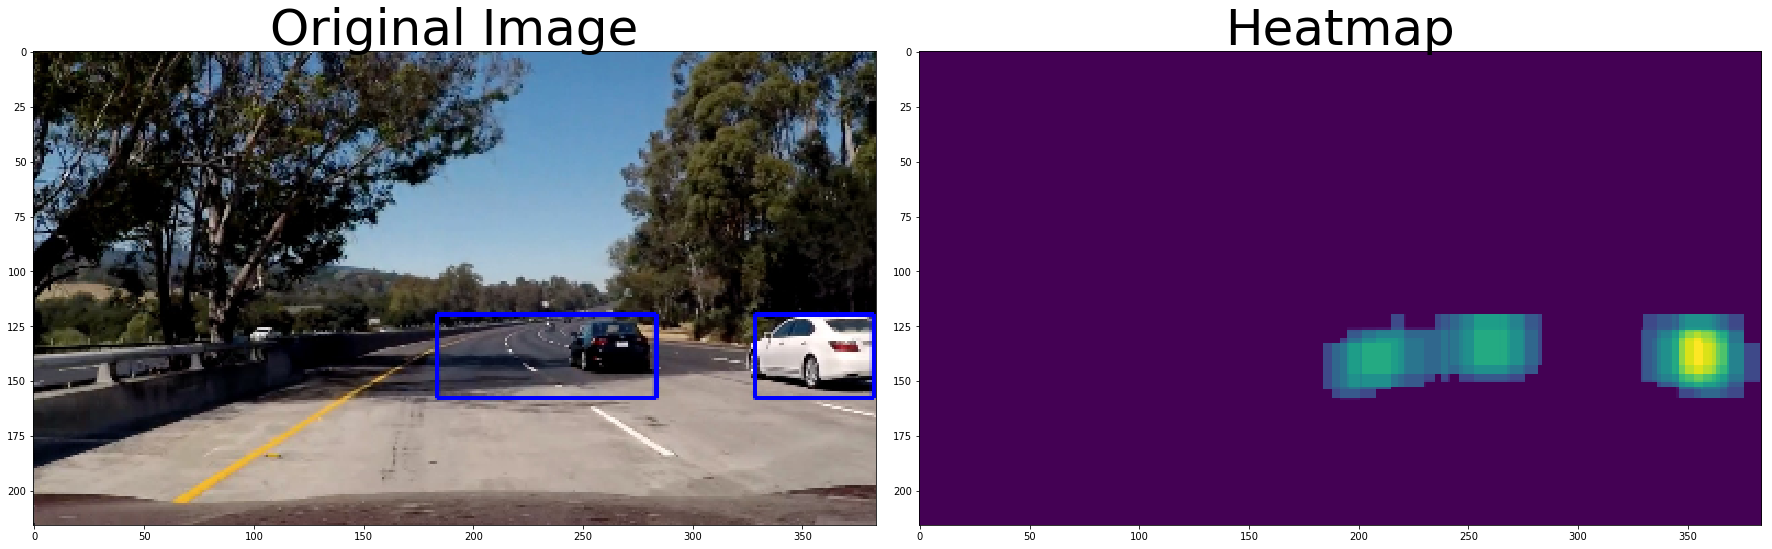

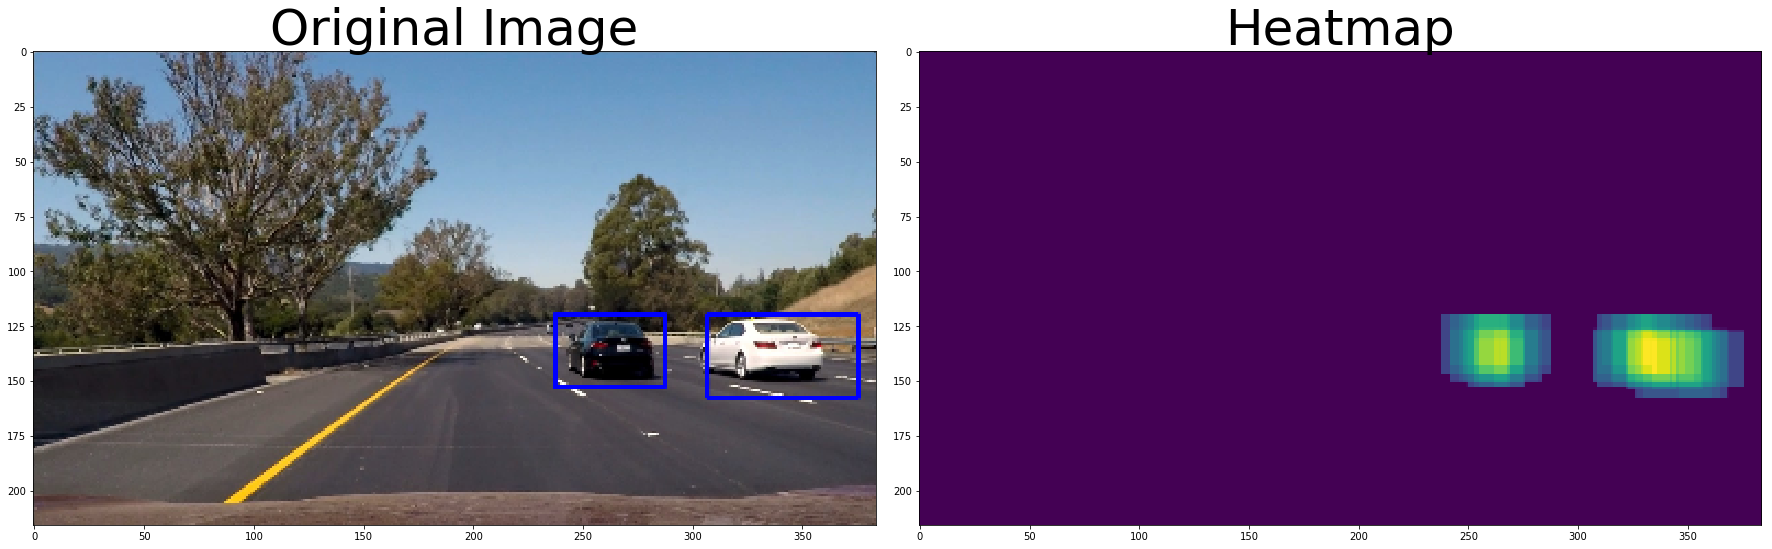

In [2]:
from scipy.ndimage.measurements import label

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def get_hog_feature(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatials(img, size=(32, 32)):
    #img = cv2.cvtColor(img,cv2.COLOR_YCrCb2RGB)
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hists(img, nbins=32, bins_range=(0, 1)):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        x1 = box[0]
        y1 = box[1]
        x2 = box[0]+box[2]
        y2 = box[1]+box[2]
        heatmap[y1:y2,x1:x2] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if(bbox[1][0]-bbox[0][0]>50) &(bbox[1][1]-bbox[0][1]>50):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
    


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    positive_boxes=[]
    
    ctrans_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    offset = 10
    if scale == 1.4 or scale == 1.6:
        cells_per_step = 1
        offset = 20
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            if xpos<offset:
                continue
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatials(subimg, size=spatial_size)
            hist_features = color_hists(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            mystack = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            test_features = X_scaler.transform(mystack)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                positive_boxes.append((xbox_left,ytop_draw+ystart,win_draw))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                           
    return positive_boxes
    
ystart = 400
ystop = 656

spatial_size = (32,32)
hist_bins = 16

test_images = glob.glob('./test_images/*.jpg')
for path in test_images:
    img = mpimg.imread(path)
    input_img = np.copy(img)
    img = img.astype(np.float32)/255
    img = convert_color(img, conv='RGB2YCrCb')
    heat_mp = np.zeros_like(img[:,:,0]).astype(np.float)
    scale = 1.4
    box_list1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.6
    box_list2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2
    box_list3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.2
    box_list4 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)



    big_list = box_list1+box_list2+box_list3+box_list4
    out_img = add_heat(heat_mp,big_list)
    thresholded = apply_threshold(out_img, threshold=3)
    heatmap = np.clip(thresholded, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(input_img, labels)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    heatmap = cv2.resize(heatmap, (0,0), fx=0.3, fy=0.3) 
    draw_img = cv2.resize(draw_img, (0,0), fx=0.3, fy=0.3) 
    ax1.imshow(draw_img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(heatmap)
    ax2.set_title('Heatmap', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video test

In [10]:
from moviepy.editor import VideoFileClip

def process_image(img):
    global frame_counter
    global final_heatmap
    global final_label
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img = convert_color(img, conv='RGB2YCrCb')
    heat_mp = np.zeros_like(img[:,:,0]).astype(np.float)
    scale = 1.4
    ystart = 400
    ystop = 530
    box_list1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.6
    ystart = 432
    ystop = 580
    box_list2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2
    ystart = 500
    ystop = 656
    box_list3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    


    big_list = box_list1+box_list2+box_list3+box_list4
    out_img = add_heat(heat_mp,big_list)
    thresholded = apply_threshold(out_img, threshold=3)
    if frame_counter==0:
        final_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        frame_counter+=1
    elif frame_counter<6:
        final_heatmap+=thresholded
        frame_counter+=1
    else:
        final_heatmap = apply_threshold(final_heatmap, threshold=10)
        heatmap = np.clip(final_heatmap, 0, 255)
        final_label = label(heatmap)
        frame_counter=0
        
    if final_label!=None:
        draw_img = draw_labeled_bboxes(draw_img, final_label)
    
    return draw_img


video_output = 'test_video_output/out_vid7.mp4'
##clip1 = VideoFileClip("project_video.mp4").subclip(5,25)
clip1 = VideoFileClip("project_video.mp4")
myclip = clip1.fl_image(process_image)
%time myclip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/out_vid7.mp4
[MoviePy] Writing video test_video_output/out_vid7.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:23<00:00,  3.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/out_vid7.mp4 

Wall time: 6min 25s
